In [263]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.simdata_i3 import I3SimBatchHandlerTFRecord
from lib.experimental_methods import get_clean_pulses_fn_v
from lib.network import get_network_eval_v_fn
from lib.geo import cherenkov_cylinder_coordinates_w_rho2_v as cherenkov_cylinder_coordinates_w_rho_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.cgamma import c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track2 as get_eval_network_doms_and_track

import time

dtype = jnp.float32
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network',
                                       dtype=dtype)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype)

'''
event_ids = ['1022', '10393', '10644', '10738', '11086', '11232', '13011',
       '13945', '14017', '14230', '15243', '16416', '16443', '1663',
       '1722', '17475', '18846', '19455', '20027', '21113', '21663',
       '22232', '22510', '22617', '23574', '23638', '23862', '24530',
       '24726', '25181', '25596', '25632', '27063', '27188', '27285',
       '28188', '28400', '29040', '29707', '3062', '31920', '31989',
       '32781', '32839', '33119', '33656', '34506', '35349', '37086',
       '37263', '37448', '37786', '37811', '39166', '39962', '40023',
       '41381', '41586', '42566', '42568', '42677', '43153', '43483',
       '4397', '44081', '48309', '48448', '48632', '49067', '50832',
       '51687', '51956', '54374', '55301', '55526', '55533', '56041',
       '5620', '56741', '56774', '57174', '57394', '57723', '59010',
       '59029', '59089', '59099', '59228', '62274', '62512', '63373',
       '65472', '6586', '8', '8604', '8674', '8840', '9410', '9419',
       '9505']
'''

event_id = 10644
tfrecord = f"/home/storage2/hans/i3files/alerts/bfrv2/event_{event_id}_N100_from_0_to_10_1st_pulse.tfrecord"

batch_maker = I3SimBatchHandlerTFRecord(tfrecord, batch_size=100)
batch_iter = batch_maker.get_batch_iterator()

# Until LLH has a noise-term, we need to remove crazy early noise pulses
clean_pulses_fn_v = get_clean_pulses_fn_v(eval_network_doms_and_track)

data, mctruth = batch_iter.next()
data = jnp.array(data.numpy())
mctruth = jnp.array(mctruth.numpy())
data_clean_padded = clean_pulses_fn_v(data, mctruth)

track_times = mctruth[:, 4]
track_positions = mctruth[:, 5:8]
track_srcs = mctruth[:,2:4]

# interesting combinations
# event 13011, DOM 10 (ranked by distance)

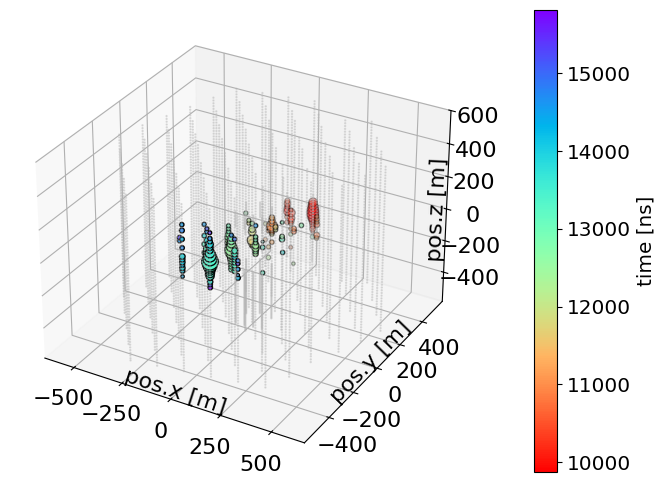

In [264]:
geo = pd.read_csv('/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')
pulses = data_clean_padded[0]
df = pd.DataFrame(data=pulses, columns = ["x", "y", "z", "time", "charge"])

def plot_event(df, geo=None):
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(projection='3d')
    ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
    ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
    ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)

    idx = df['charge'] > 0
    
    try:
        im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.5, c='0.7', alpha=0.4)
    except:
        pass
    
    im = ax.scatter(df[idx]['x'], df[idx]['y'], df[idx]['z'], s=np.sqrt(df[idx]['charge']*100), c=df[idx]['time'], 
                    cmap='rainbow_r',  edgecolors='k', zorder=1000)
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
    cb = plt.colorbar(im, orientation="vertical", pad=0.1)
    cb.set_label(label='time [ns]', size='x-large')
    cb.ax.tick_params(labelsize='x-large')
        
    plt.show()

plot_event(df, geo)

In [265]:
# extract event info
hit_x = np.array(data_clean_padded[..., 0].flatten())
hit_y = np.array(data_clean_padded[..., 1].flatten())
hit_z = np.array(data_clean_padded[..., 2].flatten())
hit_q = np.array(data_clean_padded[..., 4].flatten())

# somehow the track times are still randomized. 
# but we can subtract them out and therby standardize the hit times
track_times_ = track_times.reshape((len(track_times), 1))
hit_t = np.array((data_clean_padded[..., 3]-track_times_).flatten())

In [266]:
from collections import defaultdict

# maps each dom (x, y, z) to list of time of each first hit. and list of qtot. and single value of mean_qtot.
dom_data = defaultdict(lambda: defaultdict(list))
for i in range(len(hit_x)):
    q = hit_q[i]
    if q < 1.e-3:
        continue
        
    x = hit_x[i]
    y = hit_y[i]
    z = hit_z[i]
   
    t = hit_t[i]
    dom_data[(x,y,z)]['first_hit_time'].append(t)
    dom_data[(x,y,z)]['q_tot'].append(q)

for key in dom_data.keys():
    qs = dom_data[key]['q_tot']
    dom_data[key]['mean_q_tot'] = sum(qs)/ len(qs)

In [267]:
# create a table of dom positions
# ensure the same order as the keys in the mapping dicts for charges and times

dom_pos = []
for key in dom_data.keys():
    dom_pos.append(jnp.array(key).reshape((1,3)))

dom_pos = jnp.concatenate(dom_pos, axis=0)

# evaluate network for these doms 
# notice that all true track vertex and directions are the same. So we use the first one.
logits, av, bv, geo_time = eval_network_doms_and_track(dom_pos, track_positions[0], track_srcs[0])
mix_probs = jax.nn.softmax(logits)

# get also the other DOM info
track_dir_xyz = get_xyz_from_zenith_azimuth(track_srcs[0])

geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
            cherenkov_cylinder_coordinates_w_rho_v(dom_pos,
                                         track_positions[0],
                                         track_dir_xyz)

# convert first_hit_times to delay_times by subtracting geo_times
# and add more dom data to dom_data dict
for i in range(len(dom_pos)):
    pos = tuple(np.array(dom_pos[i]))
    gt = geo_time[i]
    for j in range(len(dom_data[pos]['first_hit_time'])):
        dom_data[pos]['first_hit_time'][j] -= float(gt)

    dom_data[pos]['closest_approach_dist'] = closest_approach_dist[i]
    dom_data[pos]['closest_approach_z'] = closest_approach_rho[i]
    dom_data[pos]['closest_approach_rho'] = closest_approach_z[i]
    dom_data[pos]['mix_probs'] = np.array(mix_probs[i])
    dom_data[pos]['a'] = np.array(av[i])
    dom_data[pos]['b'] = np.array(bv[i])

In [301]:
# charge sorted mapping
dom_positions = list(dom_data.keys())
dom_positions.sort(key=lambda x: dom_data[x]['mean_q_tot'], reverse=True)
#dom_positions.sort(key=lambda x: dom_data[x]['closest_approach_dist'] ,reverse=False)

i = 10

pos = tuple(dom_positions[i])
g_mix_p = dom_data[pos]['mix_probs']
g_a = dom_data[pos]['a']
g_b = dom_data[pos]['b']

dist = dom_data[pos]['closest_approach_dist']
z = dom_data[pos]['closest_approach_z']
rho = dom_data[pos]['closest_approach_rho']

print(g_mix_p)
print(g_a)
print(g_b)
print(dist, z, rho)

[0.36781046 0.29054021 0.34164932]
[3.52259135 5.69908428 1.93338132]
[0.02121121 0.0855362  0.0035308 ]
47.113231263786226 -0.888349450670838 -186.89337451132894


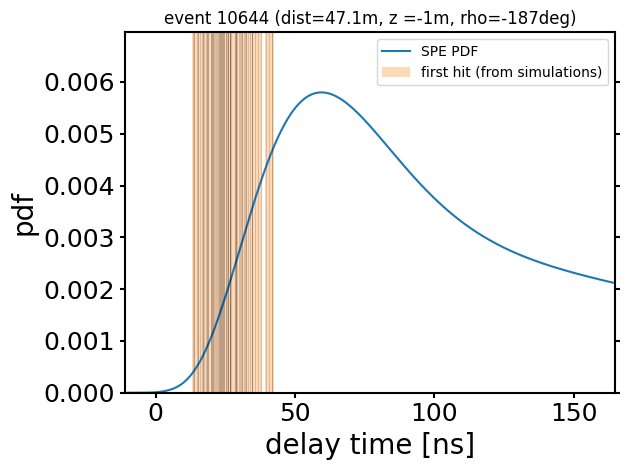

In [302]:
c_multi_gamma_prob_vx = jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0)

xvals = np.linspace(-10, 3000, 30000)

yval = c_multi_gamma_prob_vx(xvals, g_mix_p, g_a, g_b, 3.0, 0.1)
mode = (g_a[1]-1)/g_b[1]

fig, ax = plt.subplots()
plt.title(f"event {event_id} (dist={dist:.1f}m, z ={z:.0f}m, rho={rho:.0f}deg)")

plt.plot(xvals, yval, label='SPE PDF')
    
plot_args = {'xlim':[np.min([-10, np.min(dom_data[pos]['first_hit_time'])])-1 , np.max([20, 3 * mode])],
                     'ylim':[0.0, 1.2 * np.amax(yval)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

for tx in dom_data[pos]['first_hit_time']:
    plt.axvline(tx, alpha=0.2, color='black', lw=0.5)

xmax = np.max([20, 5 * np.amax(dom_data[pos]['first_hit_time'])])
plt.hist(dom_data[pos]['first_hit_time'], bins=np.linspace(-10, xmax, int((xmax+10/11))), density=True, alpha=0.3, 
         label='first hit (from simulations)')

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

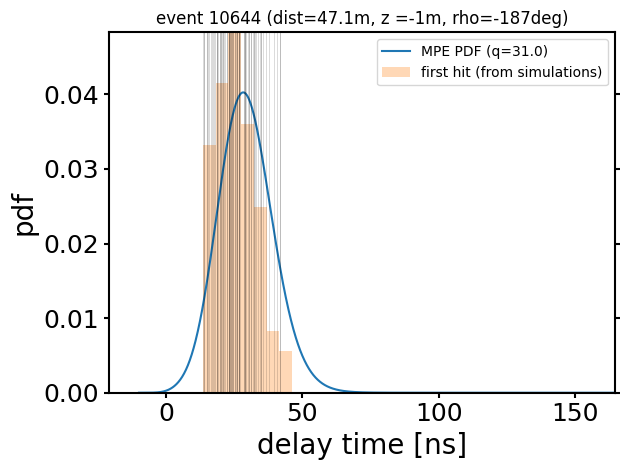

In [303]:
c_multi_gamma_sf_vx = jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0)

n_p_orig = dom_data[pos]['mean_q_tot']
n_p_orig = np.round(n_p_orig+0.5)

n_p = np.floor(np.min([3.6*np.exp(0.23*dist)+1, n_p_orig]))
n_p = np.clip(n_p, None, 10)

mode = (g_a[1]-1)/g_b[1]
fig, ax = plt.subplots()
plt.title(f"event {event_id} (dist={dist:.1f}m, z ={z:.0f}m, rho={rho:.0f}deg)")
probs = c_multi_gamma_prob_vx(xvals, g_mix_p, g_a, g_b, 3.0, 0.1)
sfs = c_multi_gamma_sf_vx(xvals, g_mix_p, g_a, g_b, 3.0)

yval1 = n_p_orig * probs * jnp.power(sfs, n_p_orig-1)
plt.plot(xvals, yval1, label=f'MPE PDF (q={n_p_orig})')

#yval2 = n_p * probs * jnp.power(sfs, n_p-1)
#plt.plot(xvals, yval2, label=f'MPE PDF (q={n_p})')

xmax = np.max([20, 5 * np.amax(dom_data[pos]['first_hit_time'])])
plot_args = {'xlim':[np.min([-20, np.min(dom_data[pos]['first_hit_time'])])-1 , np.max([20, 3 * mode])],
                     'ylim':[0.0, 1.2 * np.max([np.amax(yval1), np.max(yval2)])],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

for tx in dom_data[pos]['first_hit_time']:
    plt.axvline(tx, alpha=0.2, color='black', lw=0.5)

xmax = np.max([20, 2 * np.amax(dom_data[pos]['first_hit_time'])])
plt.hist(dom_data[pos]['first_hit_time'], bins=np.linspace(-10, xmax, 21), density=True, alpha=0.3, 
         label='first hit (from simulations)')

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()